# 1. Create Spark Session & Import Libraries

In [1]:
import findspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType, StructType, StructField
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np

findspark.init()

spark = SparkSession.builder \
    .appName("FlightDelayBatchProcessing") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/17 20:46:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 2. Define Schema & Data Preprocessing

In [2]:
schema = StructType([
    StructField("FL_DATE", StringType(), True),
    StructField("AIRLINE", StringType(), True),
    StructField("AIRLINE_DOT", StringType(), True),
    StructField("AIRLINE_CODE", StringType(), True),
    StructField("DOT_CODE", IntegerType(), True),
    StructField("FL_NUMBER", IntegerType(), True),
    StructField("ORIGIN", StringType(), True),
    StructField("ORIGIN_CITY", StringType(), True),
    StructField("DEST", StringType(), True),
    StructField("DEST_CITY", StringType(), True),
    StructField("CRS_DEP_TIME", IntegerType(), True),
    StructField("DEP_TIME", DoubleType(), True),
    StructField("DEP_DELAY", DoubleType(), True),
    StructField("TAXI_OUT", DoubleType(), True),
    StructField("WHEELS_OFF", DoubleType(), True),
    StructField("WHEELS_ON", DoubleType(), True),
    StructField("TAXI_IN", DoubleType(), True),
    StructField("CRS_ARR_TIME", IntegerType(), True),
    StructField("ARR_TIME", DoubleType(), True),
    StructField("ARR_DELAY", DoubleType(), True),
    StructField("CANCELLED", DoubleType(), True),
    StructField("CANCELLATION_CODE", StringType(), True),
    StructField("DIVERTED", DoubleType(), True),
    StructField("CRS_ELAPSED_TIME", DoubleType(), True),
    StructField("ELAPSED_TIME", DoubleType(), True),
    StructField("AIR_TIME", DoubleType(), True),
    StructField("DISTANCE", DoubleType(), True),
    StructField("DELAY_DUE_CARRIER", DoubleType(), True),
    StructField("DELAY_DUE_WEATHER", DoubleType(), True),
    StructField("DELAY_DUE_NAS", DoubleType(), True),
    StructField("DELAY_DUE_SECURITY", DoubleType(), True),
    StructField("DELAY_DUE_LATE_AIRCRAFT", DoubleType(), True)
])

data_path = "flight_data.csv"
df = spark.read.csv(data_path, header=True, schema=schema)

df = df.withColumn("FL_DATE", F.to_date(F.col("FL_DATE"), "yyyy-MM-dd"))
df.printSchema()
df.show(5, truncate=False)

columns_to_drop = [
    'AIRLINE_DOT', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN_CITY', 'DEST_CITY',
    'DEP_TIME', 'DEP_DELAY',
    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN',
    'ARR_TIME',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED',
    'ELAPSED_TIME', 'AIR_TIME',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'
]
df_cleaned = df.drop(*columns_to_drop)


df_cleaned = df_cleaned.dropna(subset=[
    "ARR_DELAY", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME",
    "DISTANCE", "ORIGIN", "DEST", "AIRLINE", "AIRLINE_CODE"
])

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- AIRLINE_DOT: string (nullable = true)
 |-- AIRLINE_CODE: string (nullable = true)
 |-- DOT_CODE: integer (nullable = true)
 |-- FL_NUMBER: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_CITY: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_CITY: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)

25/04/17 20:46:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+------------+--------+--------+-----------------+-----------------+-------------+------------------+-----------------------+
|FL_DATE   |AIRLINE              |AIRLINE_DOT              |AIRLINE_CODE|DOT_CODE|FL_NUMBER|ORIGIN|ORIGIN_CITY        |DEST|DEST_CITY            |CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|DELAY_DUE_CARRIER|DELAY_DUE_WEATHER|DELAY_DUE_NAS|DELAY_DUE_SECURITY|DELAY_DUE_LATE_AIRCRAFT|
+----------+---------------------+-------------------------+------------+--------+---------+------+-------------------+----+---------------------+

# 3. Feature Engineering

In [3]:
delay_threshold = 45

df_featured = df_cleaned.withColumn("SEVERE_DELAY", F.when(F.col("ARR_DELAY") >= delay_threshold, 1).otherwise(0))
df_featured = df_featured.withColumn("DEP_HOUR", (F.col("CRS_DEP_TIME") / 100).cast("integer"))     # dep hour
df_featured = df_featured.withColumn("DEP_MINUTE", (F.col("CRS_DEP_TIME") % 100).cast("integer"))   # dep minute
df_featured = df_featured.withColumn("ARR_HOUR", (F.col("CRS_ARR_TIME") / 100).cast("integer"))     # arrival hour
df_featured = df_featured.withColumn("ARR_MINUTE", (F.col("CRS_ARR_TIME") % 100).cast("integer"))   # arrival minute
df_featured = df_featured.withColumn("DEP_DAY_OF_WEEK", F.dayofweek(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_MONTH", F.month(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_DAY_OF_MONTH", F.dayofmonth(F.col("FL_DATE")))
df_featured = df_featured.withColumn("DEP_WEEK_OF_YEAR", F.weekofyear(F.col("FL_DATE")))
df_featured = df_featured.withColumn("IS_WEEKEND", F.when(F.col("DEP_DAY_OF_WEEK").isin([1, 7]), 1).otherwise(0))
df_featured = df_featured.withColumn("DISTANCE_PER_MINUTE", F.col("DISTANCE") / (F.col("CRS_ELAPSED_TIME") + 1e-6))


featureCols = [
    "AIRLINE_CODE", "ORIGIN", "DEST",
    "CRS_ELAPSED_TIME", "DISTANCE",
    "DEP_HOUR", "DEP_MINUTE", "ARR_HOUR", "ARR_MINUTE",
    "DEP_DAY_OF_WEEK", "DEP_MONTH", "DEP_DAY_OF_MONTH", "DEP_WEEK_OF_YEAR",
    "IS_WEEKEND", "DISTANCE_PER_MINUTE"
]

labelCol = "SEVERE_DELAY"

final_df = df_featured.select(featureCols + [labelCol, "FL_DATE"])
final_df.printSchema()
final_df.show(5, truncate=False)

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- FL_DATE: date (nullable = true)

+------------+------+----+----------------+--------+--------+----------+--------+----------+---------------+---------+----------------+----------------+----------+-------------------+------------+----------+
|AIRLINE_CODE|ORIGIN|DEST|CRS_ELAPSED_TIME|DIS

# 4. Making Visualizations

Plotting with 29276 samples.


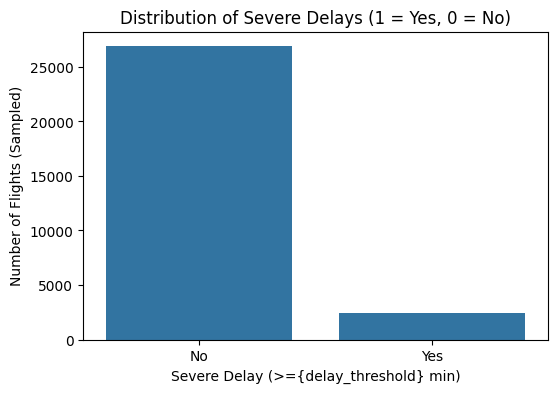

In [4]:
plot_sample_df = final_df.sample(withReplacement=False, fraction=0.01, seed=42).toPandas()
print(f"Plotting with {len(plot_sample_df)} samples.") # doing a sample because it was too large otherwise

# 1. Distribution of Severe Delays
plt.figure(figsize=(6, 4))
sns.countplot(x='SEVERE_DELAY', data=plot_sample_df)
plt.title('Distribution of Severe Delays (1 = Yes, 0 = No)')
plt.xlabel('Severe Delay (>={delay_threshold} min)')
plt.ylabel('Number of Flights (Sampled)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

In [5]:
# Getting imbalance ratio but using the full dataset for accuracy
target_counts = final_df.groupBy('SEVERE_DELAY').count().toPandas()
print("\nSevere Delay Distribution (Full Data):")
print(target_counts)
if len(target_counts) == 2:
    imbalance_ratio = target_counts['count'].min() / target_counts['count'].max()
    print(f"Imbalance Ratio: {imbalance_ratio:.4f}")

25/04/17 20:46:25 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors



Severe Delay Distribution (Full Data):
   SEVERE_DELAY    count
0             1   239470
1             0  2674332
Imbalance Ratio: 0.0895


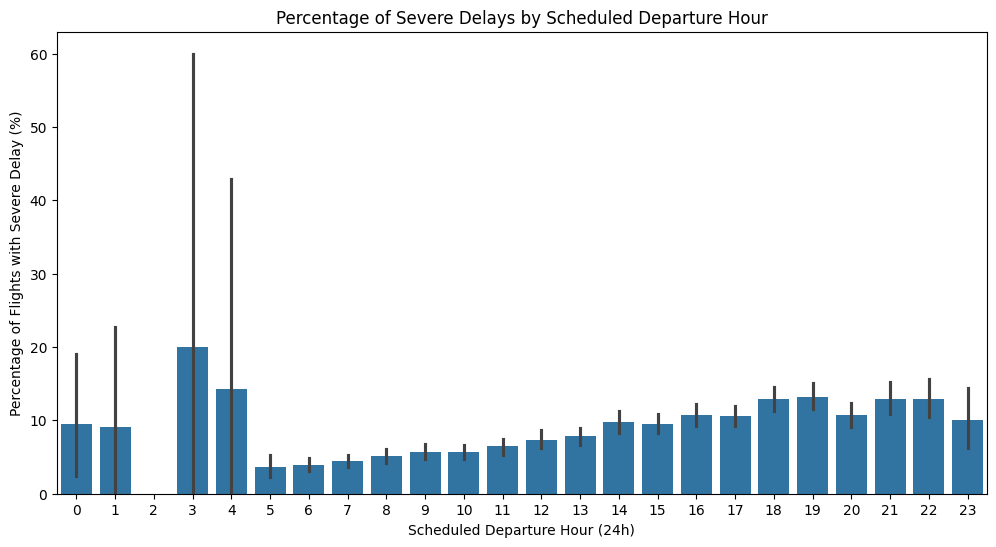

In [6]:
# 2. Barchart of delays by departure hour

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_HOUR', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title('Percentage of Severe Delays by Scheduled Departure Hour')
plt.xlabel('Scheduled Departure Hour (24h)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

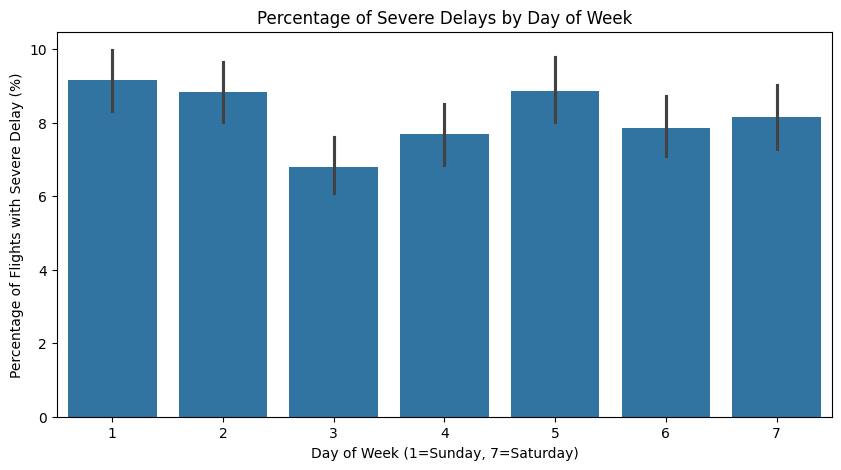

In [7]:
# 3. Delays by Day of the Week

plt.figure(figsize=(10, 5))
sns.barplot(x='DEP_DAY_OF_WEEK', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Day of Week')
plt.xlabel('Day of Week (1=Sunday, 7=Saturday)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

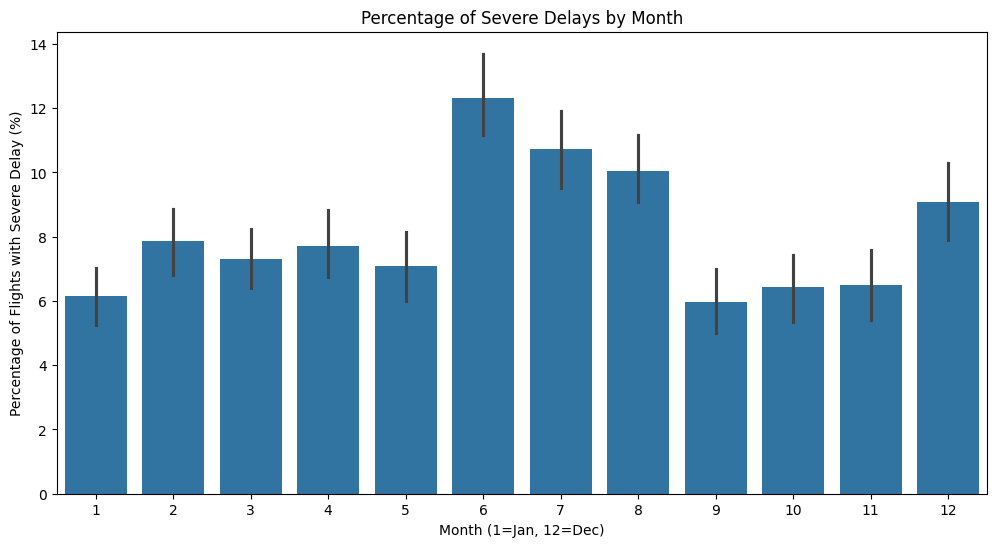

In [8]:
# 4. Delays by Month

plt.figure(figsize=(12, 6))
sns.barplot(x='DEP_MONTH', y='SEVERE_DELAY', data=plot_sample_df, estimator=lambda x: sum(x) / len(x) * 100)
plt.title(f'Percentage of Severe Delays by Month')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Percentage of Flights with Severe Delay (%)')
plt.show()

Text(0, 0.5, 'Percentage of Flights with Severe Delay (%)')

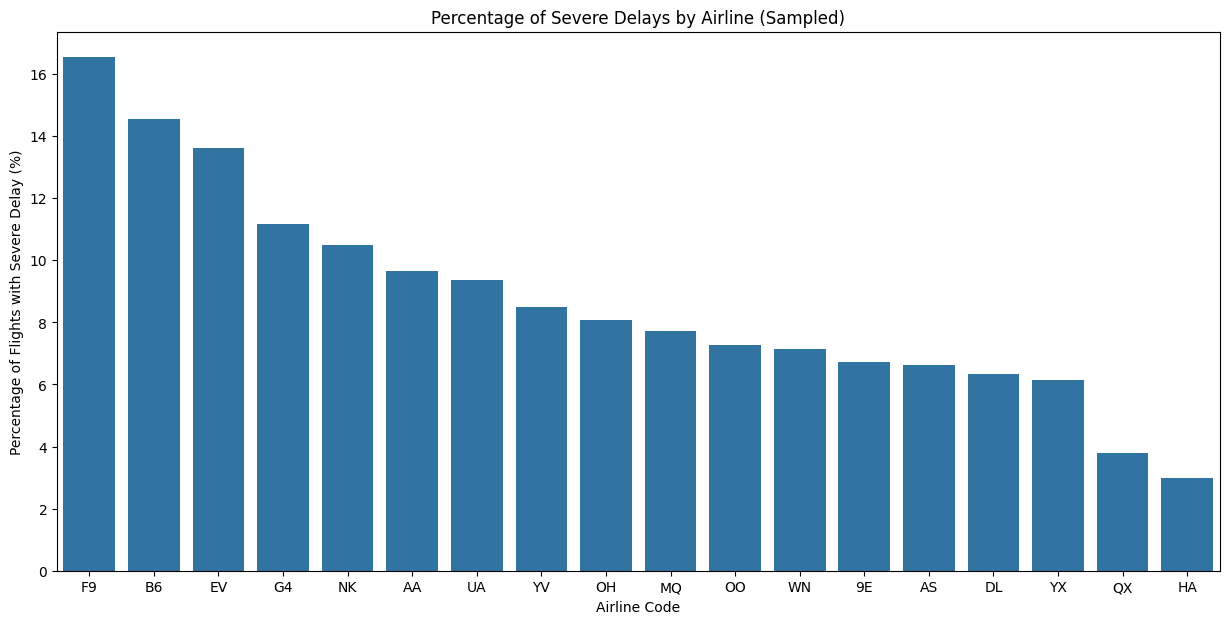

In [9]:
# 5. Top Airlines by Severe Delay Rate (using sampled data)

airline_delay_rate = plot_sample_df.groupby('AIRLINE_CODE')['SEVERE_DELAY'].mean().sort_values(ascending=False) * 100
plt.figure(figsize=(15, 7))
sns.barplot(x=airline_delay_rate.index, y=airline_delay_rate.values)
plt.title('Percentage of Severe Delays by Airline (Sampled)')
plt.xlabel('Airline Code')
plt.ylabel('Percentage of Flights with Severe Delay (%)')

Text(0.5, 0, 'Distance (miles)')

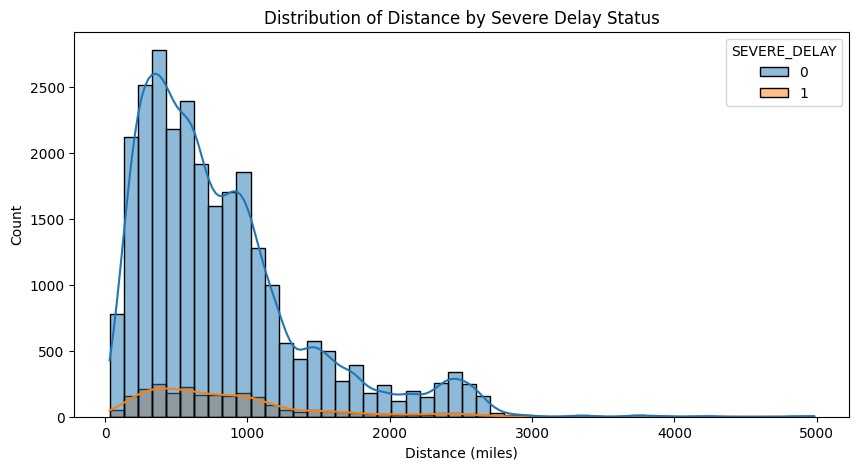

In [10]:
# 6. Numerical Feature Distributions

plt.figure(figsize=(10, 5))
sns.histplot(data=plot_sample_df, x='DISTANCE', hue='SEVERE_DELAY', kde=True, bins=50)
plt.title('Distribution of Distance by Severe Delay Status')
plt.xlabel('Distance (miles)')

# 5. Creating Pipeline

In [11]:
categorical_cols = ["AIRLINE_CODE", "ORIGIN", "DEST"]
numerical_cols = [col for col in featureCols if col not in categorical_cols]

indexers = [
    StringIndexer(inputCol = col, outputCol = col+'Index', handleInvalid = "keep")
    for col in categorical_cols
]

encoders = [
    OneHotEncoder(inputCol= col+'Index', outputCol = col+'OHE')
    for col in categorical_cols
]

In [12]:
num_vector_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="NumFeatures"
)

In [13]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True, withMean=True)

In [14]:
ohe_cols = [col+'OHE' for col in categorical_cols]
final_assembler_inputs = ohe_cols + ["ScaledNumFeatures"]

In [15]:
final_vector_assembler = VectorAssembler(
    inputCols=final_assembler_inputs,
    outputCol="features"
)

In [16]:
pipeline = Pipeline(stages = indexers + encoders + [num_vector_assembler, scaler, final_vector_assembler])

In [17]:
pipeline_model = pipeline.fit(final_df)

In [18]:
processed_df = pipeline_model.transform(final_df)
processed_df.printSchema()
processed_df.select("features", labelCol).show(5, truncate=False)

root
 |-- AIRLINE_CODE: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- DEP_HOUR: integer (nullable = true)
 |-- DEP_MINUTE: integer (nullable = true)
 |-- ARR_HOUR: integer (nullable = true)
 |-- ARR_MINUTE: integer (nullable = true)
 |-- DEP_DAY_OF_WEEK: integer (nullable = true)
 |-- DEP_MONTH: integer (nullable = true)
 |-- DEP_DAY_OF_MONTH: integer (nullable = true)
 |-- DEP_WEEK_OF_YEAR: integer (nullable = true)
 |-- IS_WEEKEND: integer (nullable = false)
 |-- DISTANCE_PER_MINUTE: double (nullable = true)
 |-- SEVERE_DELAY: integer (nullable = false)
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE_CODEIndex: double (nullable = false)
 |-- ORIGINIndex: double (nullable = false)
 |-- DESTIndex: double (nullable = false)
 |-- AIRLINE_CODEOHE: vector (nullable = true)
 |-- ORIGINOHE: vector (nullable = true)
 |-- DESTOHE: vector (nullable 

# 6. Training Random Forest Model

In [19]:
model_data = processed_df.select("features", labelCol).withColumnRenamed(labelCol, "label")
train_df, test_df = model_data.randomSplit([0.8, 0.2], seed=101)

# i am only using half the data because it broke it otherwise
train_df_sampled = train_df.sample(withReplacement=False, fraction=0.5, seed=101)
print(f"Using {train_df_sampled.count()} samples for training after extra sampling.")

[Stage 19:====================================>                     (5 + 3) / 8]

Using 1166305 samples for training after extra sampling.


In [ ]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label",
                            numTrees=100,
                            maxDepth=10,
                            seed=101)

rf_model = rf.fit(train_df_sampled)

25/04/17 20:47:35 WARN MemoryStore: Not enough space to cache rdd_91_5 in memory! (computed 379.6 MiB so far)
25/04/17 20:47:35 WARN BlockManager: Persisting block rdd_91_5 to disk instead.
25/04/17 20:47:35 WARN MemoryStore: Not enough space to cache rdd_91_4 in memory! (computed 379.6 MiB so far)
25/04/17 20:47:35 WARN BlockManager: Persisting block rdd_91_4 to disk instead.
25/04/17 20:47:36 WARN MemoryStore: Not enough space to cache rdd_91_0 in memory! (computed 379.6 MiB so far)
25/04/17 20:47:36 WARN BlockManager: Persisting block rdd_91_0 to disk instead.
25/04/17 20:47:36 WARN MemoryStore: Not enough space to cache rdd_91_1 in memory! (computed 379.6 MiB so far)
25/04/17 20:47:36 WARN BlockManager: Persisting block rdd_91_1 to disk instead.
25/04/17 20:47:36 WARN MemoryStore: Not enough space to cache rdd_91_2 in memory! (computed 379.6 MiB so far)
25/04/17 20:47:36 WARN BlockManager: Persisting block rdd_91_2 to disk instead.
[Stage 31:>                                       

In [ ]:
predictions = rf_model.transform(test_df)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"\nTest Set Area Under ROC (AUC): {auc:.4f}")

In [ ]:
evaluator_multi = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")

accuracy = evaluator_multi.setMetricName("accuracy").evaluate(predictions)
# we are using the weighted metrics because of the imbalance in the data
precision = evaluator_multi.setMetricName("weightedPrecision").evaluate(predictions)
recall = evaluator_multi.setMetricName("weightedRecall").evaluate(predictions)
f1 = evaluator_multi.setMetricName("f1").evaluate(predictions)

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Weighted Precision: {precision:.4f}")
print(f"Test Set Weighted Recall: {recall:.4f}")
print(f"Test Set F1 Score: {f1:.4f}")

In [ ]:
preds_and_labels = predictions.select("prediction", "label").rdd.map(lambda row: (float(row.prediction), float(row.label)))
metrics = MulticlassMetrics(preds_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

print("\nConfusion Matrix:")
print(confusion_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Predicted 0 (No Delay)", "Predicted 1 (Severe Delay)"],
            yticklabels=["Actual 0 (No Delay)", "Actual 1 (Severe Delay)"])
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
pipeline_path = "./flight_delay_pipeline_model"
model_path = "./flight_delay_rf_model"

print(f"\nSaving preprocessing pipeline model to: {pipeline_path}")
pipeline_model.write().overwrite().save(pipeline_path)
print("Pipeline model saved.")

print(f"\nSaving RandomForest model to: {model_path}")
rf_model.write().overwrite().save(model_path)
print("RandomForest model saved.")

spark.stop()
print("\nSpark Session Stopped.")